In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import time


from openparticle.hamiltonians.free_hamiltonians import free_boson_Hamiltonian, free_fermion_Hamiltonian
from openparticle.hamiltonians.yukawa_hamiltonians import *
from openparticle.hamiltonians.renormalized_yukawa_hamiltonian import *
from openparticle.utils import *
from openparticle.dlcq import momentum_states_partition, pdf


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.rc('text', usetex=True)

/Users/carterm.gustin/anaconda3/envs/openparticle/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-02 13:36:32,603	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
def get_eigenstates(resolutions, g, mf, mb, Q, num_eigenstates, n_particles: int = None):
    eigenvalues = []
    eigenstates = []

    initial_time = time.time()
    for res in resolutions:
        print("---K = ", res, "---")
        res_time_init = time.time()
        # hamiltonian = yukawa_Hamiltonian(res = res, g = g, mf = mf, mb = mb)
        hamiltonian = yukawa_Hamiltonian(res = res, g = g, mf = mf, mb = mb)
        print("Size of Hamiltonian:", len(hamiltonian))
        print("Hamiltonian generation:", time.time() - res_time_init)
        res_time_init = time.time()
        res_tmp_basis = momentum_states_partition(res, n_particles = n_particles)
        print("Basis generation:", time.time() - res_time_init)
        res_time_init = time.time()
        baryon_number_basis = impose_baryon_number(res, res_tmp_basis, baryon_number=Q)
        res_time_init = time.time()
        print("Size of Q+cutoff basis:", len(baryon_number_basis))
        
        print("Matrix generation...")
        # tmp_mat = generate_matrix(hamiltonian, cutoff_basis)
        tmp_mat = generate_matrix_hermitian(hamiltonian, baryon_number_basis)
        print("Matrix generation:",  time.time() - res_time_init)
        res_time_init = time.time()


        # tmp_mat = generate_matrix(hamiltonian, baryon_number_basis)
        if tmp_mat.shape != (0, 0):
            print("Calculating eigenvalues...")
            vals, vecs = np.linalg.eigh(tmp_mat)
            print("Eigenvalues:", time.time() - res_time_init)
            vals = sorted(vals)
        eigenvalues.append(vals[:num_eigenstates])
        for i in range(0, num_eigenstates):
            eigenstates.append(numpy_to_fock(vecs[:, i], baryon_number_basis))
        
    
    K_values = np.arange(1, len(eigenvalues) + 1)
    max_eigenvalues = max(len(eig) for eig in eigenvalues)

    padded_eigenvalues = np.array([
        np.pad(eig, (0, max_eigenvalues - len(eig)), constant_values=np.nan)
        for eig in eigenvalues
    ])

    padded_eigenvalues = padded_eigenvalues.T

    return padded_eigenvalues, eigenstates

In [3]:
max_res = 10
mf = 1
mb = 1
g = 4
t = 0.1
Q = 0
num_eigenstates = 5
n_particles = 2

resolutions = [max_res]

eigenvalues, eigenvectors = get_eigenstates(resolutions, g = 1, mf = 1, mb = 0.1, Q = 0, num_eigenstates = num_eigenstates, n_particles = n_particles)

---K =  10 ---
Size of Hamiltonian: 3730
Hamiltonian generation: 51.75958490371704
Basis generation: 0.001870870590209961
Size of Q+cutoff basis: 16
Matrix generation...
Matrix generation: 1.3569538593292236
Calculating eigenvalues...
Eigenvalues: 0.005285739898681641


Text(0, 0.5, '$xf(x)$')

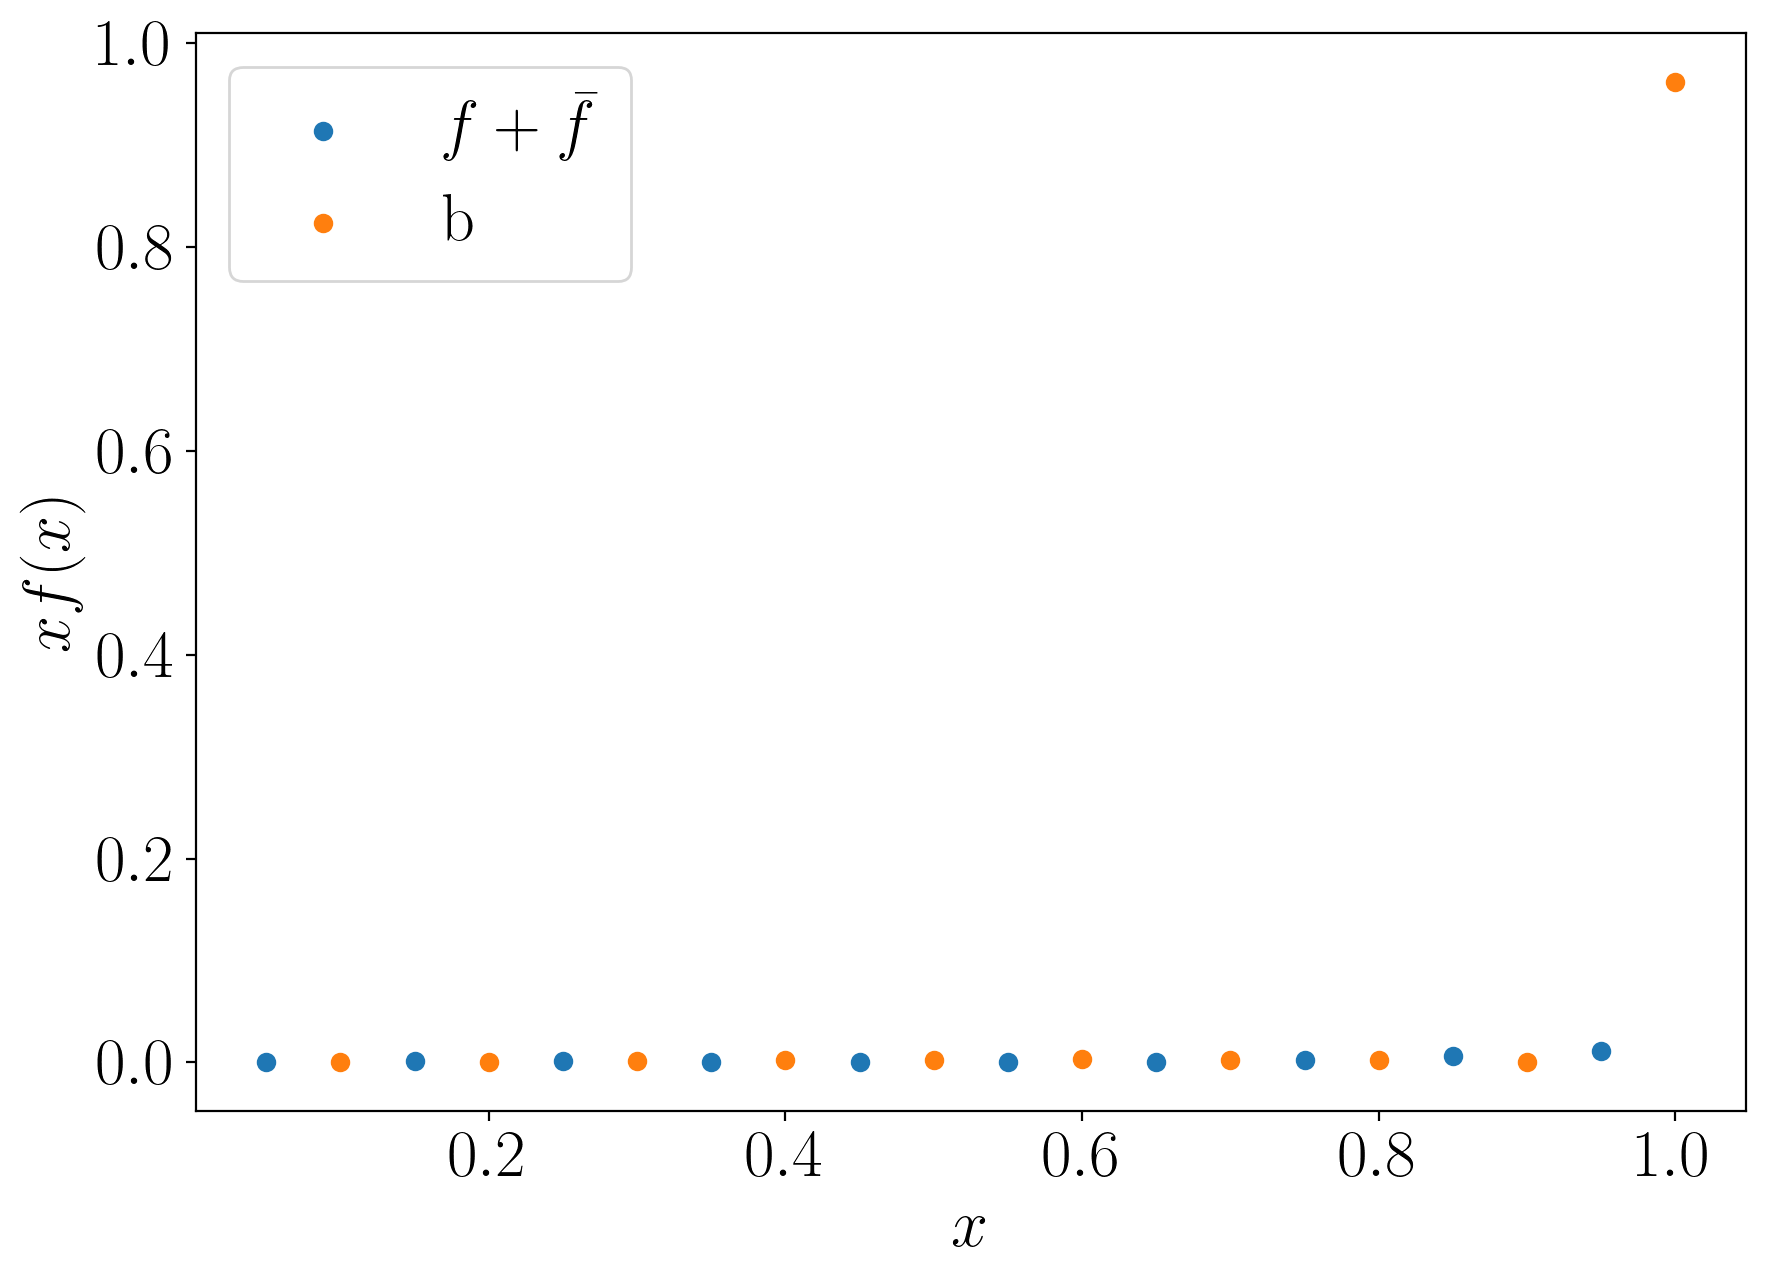

In [14]:
psi = eigenvectors[0]
res = max_res

fermion_pdf = pdf(res, psi, 'fermion')
antifermion_pdf = pdf(res, psi, 'antifermion')
boson_pdf = pdf(res, psi, 'boson')

x_fermion = np.array([k/res for k in np.arange(1/2, res, 1)])
x_boson = np.array([k/res for k in np.arange(1, res + 1, 1)])


plt.figure(figsize = (10, 7), dpi = 200)

if np.allclose(fermion_pdf, antifermion_pdf):
    plt.scatter(x_fermion, 2 * x_fermion * np.real(fermion_pdf), label = r'$f+ \bar{f}$')

else:
    plt.scatter(x_fermion, x_fermion * np.real(fermion_pdf), label = f'Fermion')
    plt.scatter(x_fermion, x_fermion * np.real(antifermion_pdf), label = f'Antifermion')
plt.scatter(x_boson, x_boson * np.real(boson_pdf), label = f'b')


# plt.scatter([], [], color = 'white', label = f'{max_weight}')
plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$xf(x)$')
# plt.title(f"Yukawa $Q = {baryon_number}$ bound state PDF")

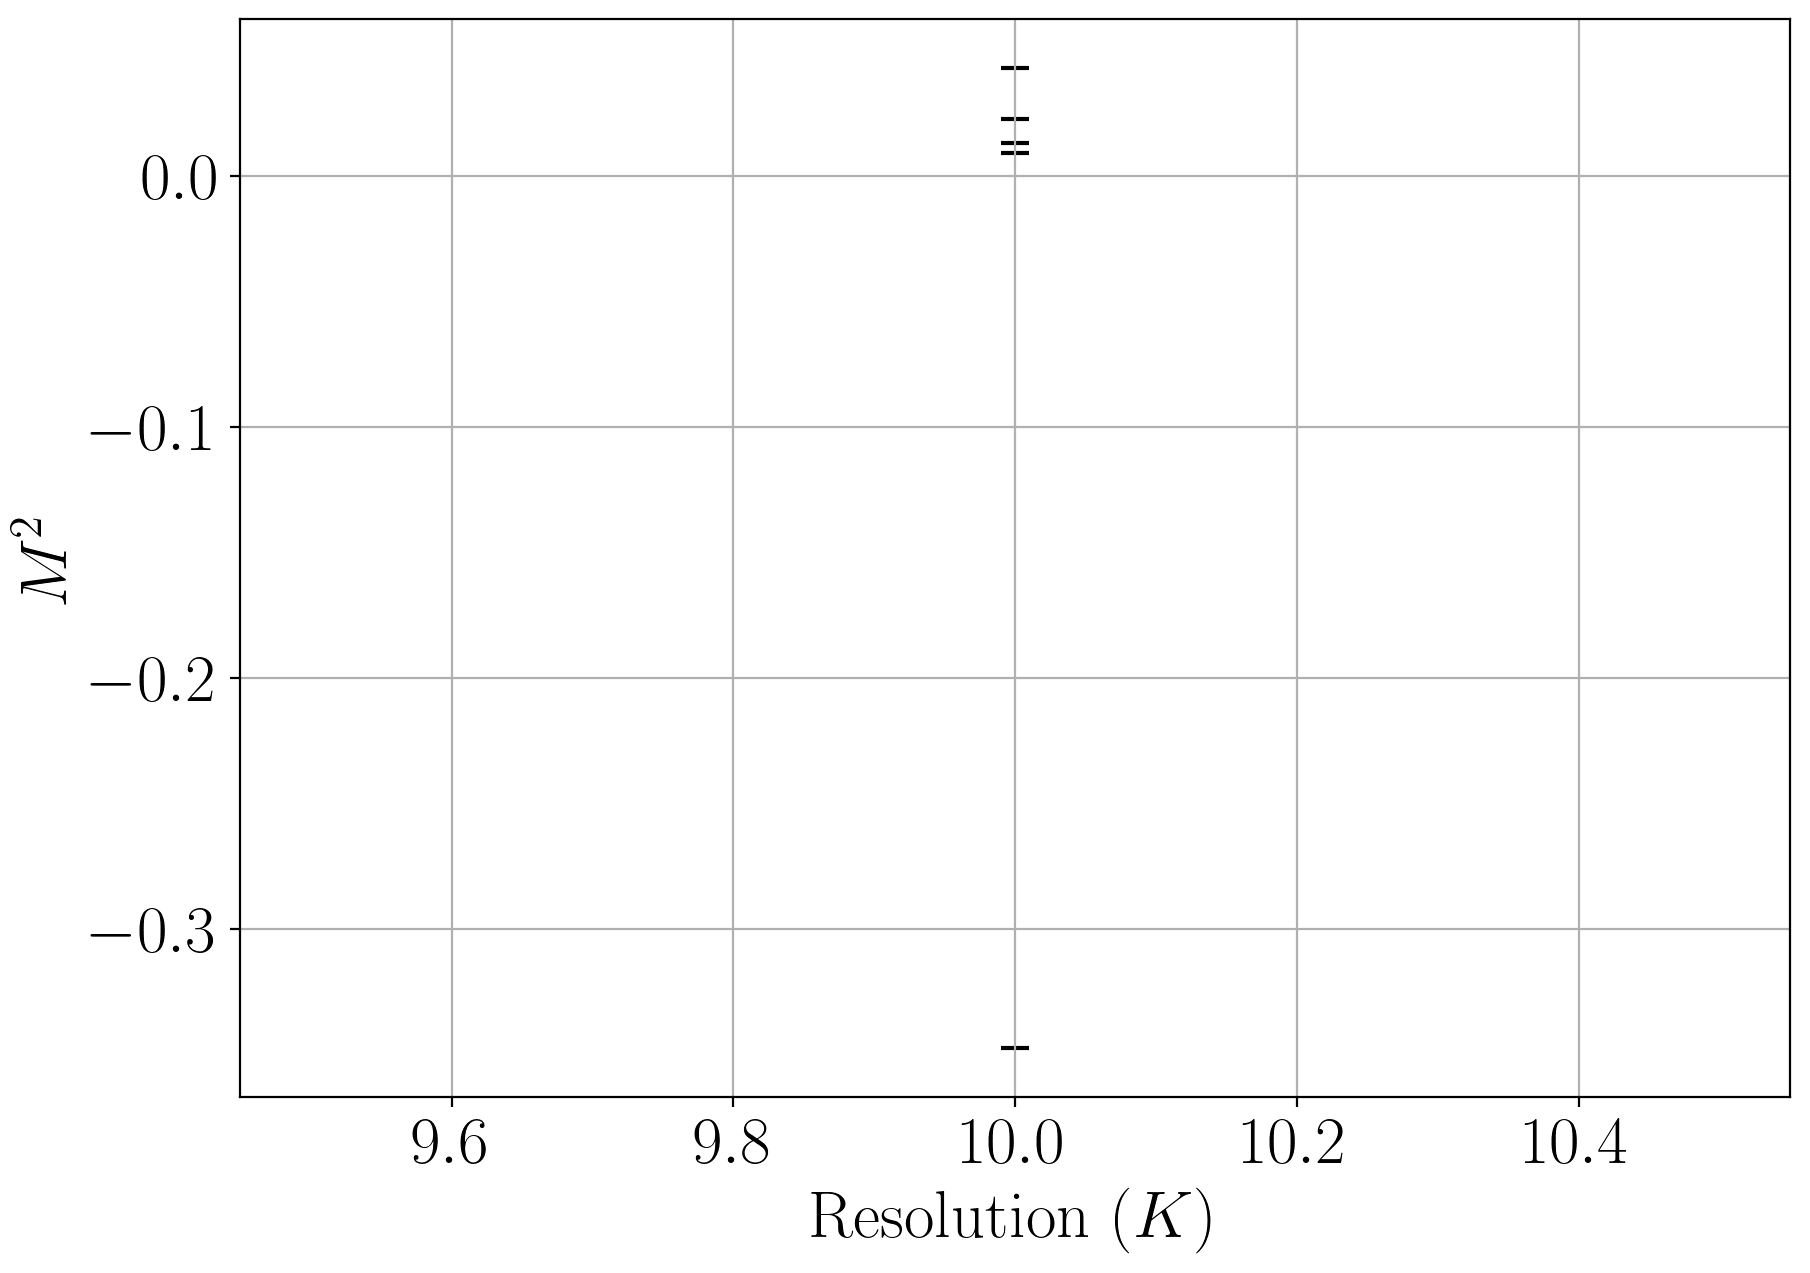

In [5]:
plt.figure(figsize = (10, 7), dpi = 200)
K_values = range(1, max_res + 1)
colors = plt.cm.viridis(np.linspace(0, 1, eigenvalues.shape[0]))
for i, eig in enumerate(eigenvalues):
    # plt.plot(K_values, eig, color = colors[i], marker='o', label=f" $E_{i}$")#, label=f" $E_{i}$")#colors = colors[i]
    plt.scatter(resolutions, eig, color = 'black', marker = '_', s = 100)

plt.xlabel("Resolution ($K$)")
plt.ylabel("$M^2$")
# plt.title( f'g = {g}, $m_f$ = {mf}, $m_b$ = {mb}')
# plt.legend()
# plt.yscale('symlog')
plt.grid()
plt.show()

In [162]:
def m2_vs_res(res_vals, baryon_number, coupling = 1, mf = 1, mb = 1, eigenstate = 0):


    evals = []
    # K_vals = list(range(1, res_vals + 1))
    L_vals = []

    for res in res_vals:
        ham = yukawa_Hamiltonian(res = res, g = coupling, mf=mf, mb = mb)
        K_tmp_basis = momentum_states_partition(res)
        baryon_number_basis = impose_baryon_number(res, K_tmp_basis, baryon_number=baryon_number)
        # cutoff_states = impose_fock_sector_cutoff(baryon_number_basis, n_particles)

        tmp_mat = generate_matrix(ham, baryon_number_basis)

        if tmp_mat.shape != (0, 0):
            vals, vecs = np.linalg.eigh(tmp_mat)
            evals.append(sorted(vals)[eigenstate])
            L_vals.append(2*np.pi * res)
            psi = numpy_to_fock(vecs[:, eigenstate], baryon_number_basis)
            max_weight, state = max_fock_weight(psi)
            # print(res, max_weight *  state, sorted(vals)[eigenstate])
            print(res, psi, sorted(vals)[eigenstate])

    return evals


3 0.0 * |((), (), ())⟩ +
(3.714977792133336e-17+0j) * |((), (), ((0, 3),))⟩ +
(-1.0342512121028394e-16+0j) * |((), (), ((0, 1), (1, 1)))⟩ +
(1.660218111259597e-16+0j) * |((), (), ((2, 1),))⟩ +
(0.542347047535803+0j) * |((0,), (0,), ((0, 2),))⟩ +
(0.17134820440755077+0j) * |((0,), (0,), ((1, 1),))⟩ +
(-0.3462211792562958+0j) * |((0,), (1,), ((0, 1),))⟩ +
(-0.3168706165950509+0j) * |((0,), (2,), ())⟩ +
(-0.34622117925629625+0j) * |((1,), (0,), ((0, 1),))⟩ +
(-0.4857440556729536+0j) * |((1,), (1,), ())⟩ +
(-0.31687061659505017+0j) * |((2,), (0,), ())⟩ 7.217075011561886
4 0.0 * |((), (), ())⟩ +
(0.04365467869161545+0j) * |((), (), ((0, 4),))⟩ +
(-0.07474025907813295+0j) * |((), (), ((0, 2), (1, 1)))⟩ +
(0.1524679482745251+0j) * |((), (), ((0, 1), (2, 1)))⟩ +
(-0.06965641464978664+0j) * |((), (), ((1, 2),))⟩ +
(-0.06768337982312836+0j) * |((), (), ((3, 1),))⟩ +
(-1.3072119446789726e-16+0j) * |((0,), (0,), ((0, 3),))⟩ +
(-3.217821759258104e-17+0j) * |((0,), (0,), ((0, 1), (1, 1)))⟩ +
(-1.561

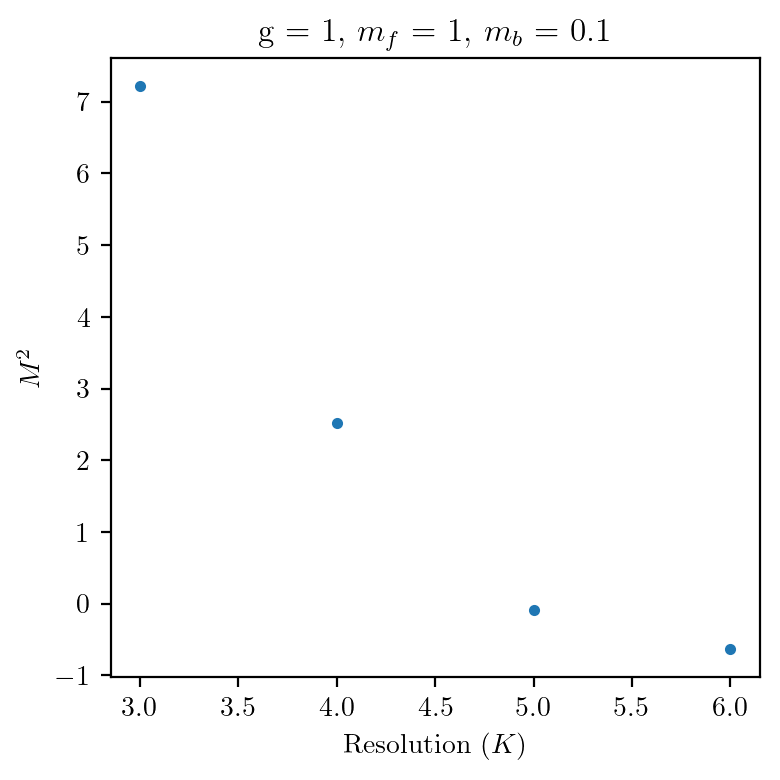

In [163]:
res = 6
g = 1
mf = 1
mb = 0.1
n_particles = 10
# kvals = [2**p for p in range(1, res)]
kvals = list(range(3, res + 1))
plt.figure(figsize = (4, 4), dpi = 200)
e = m2_vs_res(res_vals=kvals, baryon_number = 0, coupling = g, mf = mf, mb = mb, eigenstate = 6)
plt.scatter(kvals, np.array(e), marker='.')
# plt.scatter([], [], color = 'white', label = f'g = {g}, $m_f$ = {mf}, $m_b$ = {mb}')
plt.xlabel('Resolution ($K$)')
plt.ylabel(f'$M^2$')
plt.title( f'g = {g}, $m_f$ = {mf}, $m_b$ = {mb}')
plt.tight_layout()
# plt.legend()
plt.show()


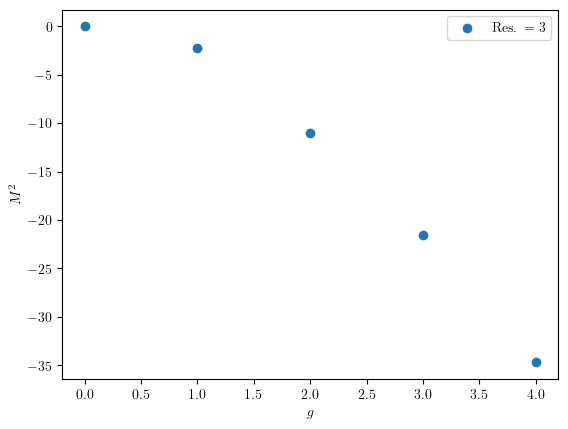

In [8]:
resolution = 3

mf = 1
mb = 0.1
K_tmp_basis = momentum_states_partition(res)
baryon_number_basis = impose_baryon_number(res, K_tmp_basis, baryon_number=0)

m2 = []
for coupling in range(0, 5):
    ham = yukawa_Hamiltonian(res = resolution, g = coupling, mf=mf, mb = mb)
    tmp_mat = generate_matrix(ham, baryon_number_basis)
    m2.append(min(np.linalg.eigvalsh(tmp_mat)))
plt.scatter(np.arange(0, 5, 1), m2, label = f'Res. = {resolution}')
plt.xlabel(f'$g$')
plt.ylabel(
    f'$M^2$'
)
plt.legend()

### Partition $H$ into blocks of definite $P^+$

Text(0.5, 1.0, 'Yukawa Hamiltonian at $L = 4\\pi$')

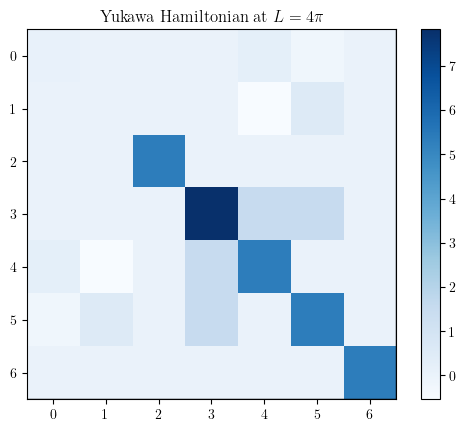

In [9]:
res = 2
min_res = res
g = 1
mf = 1
mb = 0.1

t = 0.1
treg = 0.01

basis = [momentum_states_partition(i)[j] for i in range(min_res, res + 1) for j in range(len(momentum_states_partition(i)))]
matrix = np.real(
        generate_matrix(yukawa_Hamiltonian(res, g = g, mf = mf, mb = mb), basis)
    )
# matrix = np.real(
#         generate_matrix(renormalized_Yukawa_hamiltonian(res = res, t = t, treg = treg, g = g, mf = mf, mb = mb), basis)
#     )
plt.imshow(
    matrix,
    cmap = 'Blues',
)
n_states_i = 0
for i in range(min_res, res + 1):
    n_states_i += len(momentum_states_partition(i))
    plt.axvline(x=n_states_i - 0.5, color='black', linewidth=1)
    plt.axhline(y=n_states_i - 0.5, color='black', linewidth=1)
plt.colorbar()
plt.title(f'Yukawa Hamiltonian at $L = {2 * res}\pi$')

Text(0.5, 1.0, 'Yukawa $Q = 0$ bound state PDF')

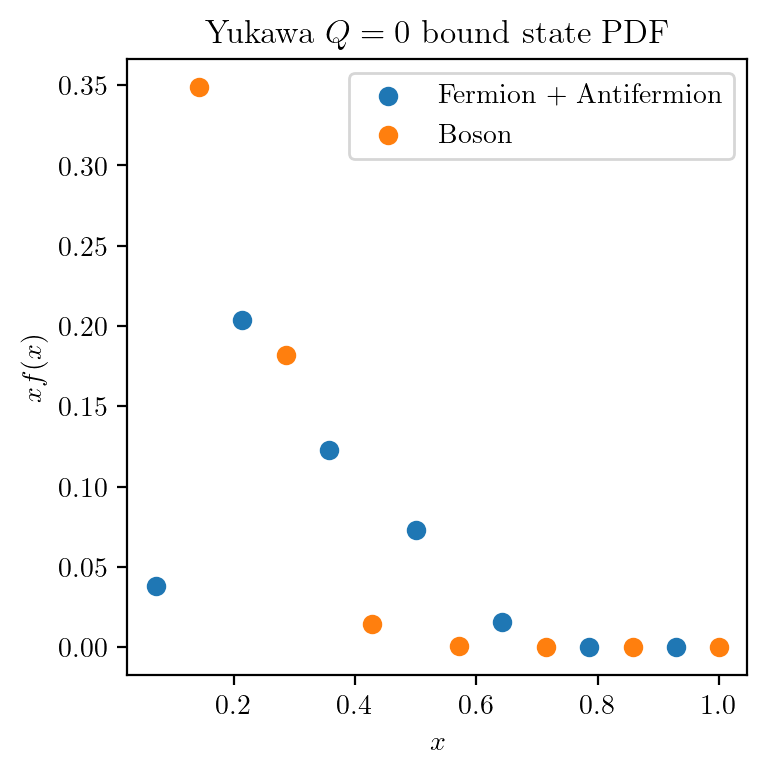

In [235]:
res = 7
g = 1
mf = 1
mb = 0.1
baryon_number = 0
eigenstate = 1

ham = yukawa_Hamiltonian(res = res, g = g, mf = mf, mb = mb)
basis = momentum_states_partition(res)
basis = impose_baryon_number(res = res, basis = basis, baryon_number=baryon_number)
K_matrix = generate_matrix(ham, basis)

vals, vecs = np.linalg.eigh(K_matrix)
psi = numpy_to_fock(vecs[:, eigenstate], basis)
max_weight, _ = max_fock_weight(psi)

fermion_pdf = pdf(res, psi, 'fermion')
antifermion_pdf = pdf(res, psi, 'antifermion')
boson_pdf = pdf(res, psi, 'boson')

x_fermion = np.array([k/res for k in np.arange(1/2, res, 1)])
x_boson = np.array([k/res for k in np.arange(1, res + 1, 1)])


plt.figure(figsize = (4, 4), dpi = 200)

if np.allclose(fermion_pdf, antifermion_pdf):
    plt.scatter(x_fermion, 2 * x_fermion * np.real(fermion_pdf), label = f'Fermion $+$ Antifermion')

else:
    plt.scatter(x_fermion, x_fermion * np.real(fermion_pdf), label = f'Fermion')
    plt.scatter(x_fermion, x_fermion * np.real(antifermion_pdf), label = f'Antifermion')
plt.scatter(x_boson, x_boson * np.real(boson_pdf), label = f'Boson')
# plt.scatter([], [], color = 'white', label = f'{max_weight}')
plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$xf(x)$')
# plt.xscale('log')
plt.title(f"Yukawa $Q = {baryon_number}$ bound state PDF")

## New $\mathcal{O}(g^2)$ Diagrams

In [2]:
def renormalized_m2_vs_res(res_vals, t, treg, g, mf, mb, baryon_number):


    evals = []
    # K_vals = list(range(1, res_vals + 1))
    L_vals = []

    for res in res_vals:
        ham = renormalized_Yukawa_hamiltonian(res = res, t = t, treg = treg, g = g, mf = mf, mb = mb)
        K_tmp_basis = momentum_states_partition(res)
        baryon_number_basis = impose_baryon_number(res, K_tmp_basis, baryon_number=baryon_number)

        tmp_mat = generate_matrix(ham, baryon_number_basis)

        if tmp_mat.shape != (0, 0):
            vals, vecs = np.linalg.eigh(tmp_mat)

            evals.append(min(vals))
            L_vals.append(2*np.pi * res)
            psi = numpy_to_fock(vecs[:, 0], baryon_number_basis)
            max_weight, state = max_fock_weight(psi)
            print(res, max_weight *  state, min(vals))
            # print(res, psi, min(vals))

    return evals


1 (1+0j) * |((), (), ((0, 1),))⟩ 0.037690710762723414
2 (0.999998440425056+0j) * |((), (), ((1, 1),))⟩ 0.023786320985680467
3 (-0.9999998606260679+0j) * |((), (), ((2, 1),))⟩ 0.01922428978429055
4 (0.9999927193447437+0j) * |((), (), ((3, 1),))⟩ 0.016867351921019676
5 (0.9999953154861895+0j) * |((), (), ((4, 1),))⟩ 0.015470014110198837


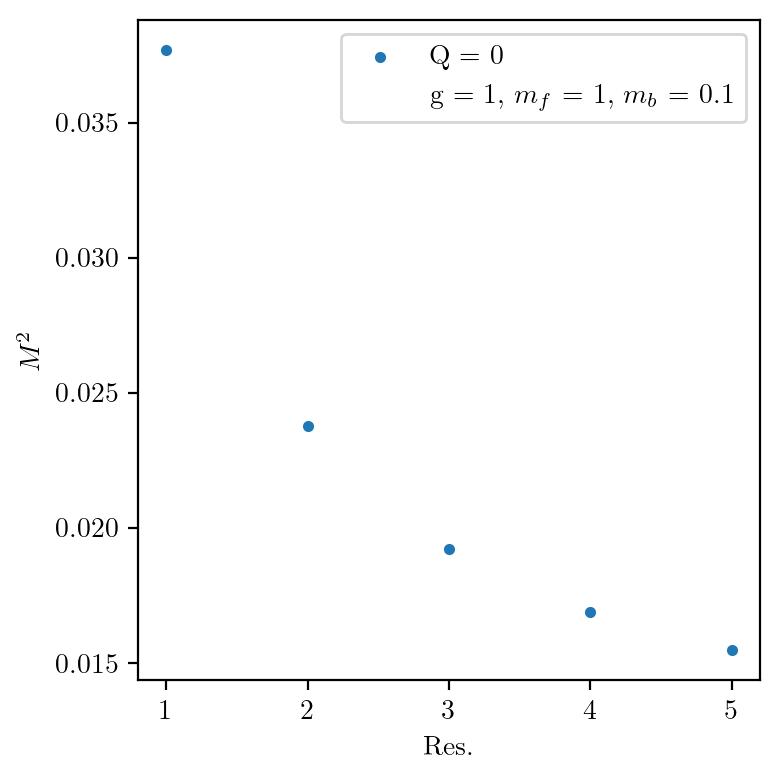

In [34]:
res = 5
t = 0.1
treg = 0
mf = 1
mb = 0.1
g = 1

kvals = list(range(1, res + 1))
plt.figure(figsize = (4, 4), dpi = 200)
e = renormalized_m2_vs_res(res_vals=kvals, t = t, treg = treg, g = g, mf = mf, mb = mb, baryon_number=0)
plt.scatter(kvals, np.array(e), marker='.', label = 'Q = 0')
plt.scatter([], [], color = 'white', label = f'g = {g}, $m_f$ = {mf}, $m_b$ = {mb}')
plt.xlabel('Res.')
plt.ylabel(f'$M^2$')
plt.tight_layout()
plt.legend()

plt.show()

1 (1+0j) * |((), (), ((0, 1),))⟩ 0.01584029267068993
2 (0.999939869891858+0j) * |((), (), ((1, 1),))⟩ 0.012121349715917613
3 (0.9999183603488754+0j) * |((), (), ((2, 1),))⟩ 0.01061217422246114
4 (0.9999109714103549+0j) * |((), (), ((3, 1),))⟩ 0.009791665149913
5 (-0.999909203077289+0j) * |((), (), ((4, 1),))⟩ 0.009303870421615647
1 (1+0j) * |((), (), ((0, 1),))⟩ 0.012463680298197822
2 (0.999957713338134+0j) * |((), (), ((1, 1),))⟩ 0.010712822961662902
3 (0.9999640299298393+0j) * |((), (), ((2, 1),))⟩ 0.010264124316808215
4 (0.9999734021955269+0j) * |((), (), ((3, 1),))⟩ 0.010180826761190283
5 (0.9999774867740422+0j) * |((), (), ((4, 1),))⟩ 0.01016184516650082
1 (1+0j) * |((), (), ((0, 1),))⟩ 0.010276907107627235
2 (0.9999996990231566+0j) * |((), (), ((1, 1),))⟩ 0.010135056228278632
3 (-0.9999999964101922+0j) * |((), (), ((2, 1),))⟩ 0.010092249340055565
4 (-0.9999996988799492+0j) * |((), (), ((3, 1),))⟩ 0.010066552433327831
5 (0.9999997407955167+0j) * |((), (), ((4, 1),))⟩ 0.01005284754

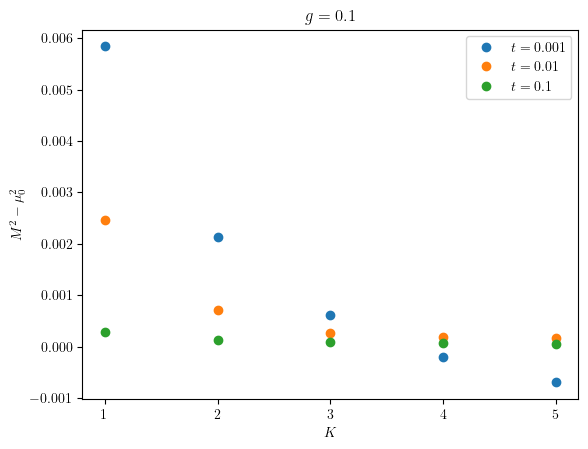

In [25]:
res = 5
mb = 0.1
g = 0.1
fig, ax = plt.subplots()
reses = [1, 2, 3, 4, 5]

for t in [0.001, 0.01, 0.1]:
    ham = renormalized_Yukawa_hamiltonian(res = res, t = t, treg = 0, g = g, mf = 1, mb = mb)
    e = renormalized_m2_vs_res(res_vals=reses, t = t, treg = treg, g = g, mf = mf, mb = mb, baryon_number=0)
    L = 2*np.pi * res
        # mus = []
        # ks = []
    # for term, coeff in ham.op_dict.items():
    #     if 2 in [t[0] for t in term] and len(term) == 2:
    #         mode = term[0][1]
    #         k = mode + 1
    #         mu = coeff * p(k, L)
    #         ks.append(k)
    #         mus.append(mu)


    ax.plot(reses, np.array(e) - mb**2, ls = "", label = f'$t = {t}$', marker="o")

# ax.axhline(y=mb**2, color="black", alpha = 1, linewidth = 1)

# ax.axhline(y=e, color="black", alpha = 1, linewidth = 1)


# yticks = [0, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1]
# yticklabels = [0, f'$M^2, \mu^2_0$', 0.02,  0.04, 0.06, 0.08, 0.1]
# ax.set_yticks(yticks)
# ax.set_yticklabels(yticklabels)
# ax.set_xticks(ks)


plt.ylabel(f'$M^2 - \mu_0^2$')
plt.xlabel('$K$')
plt.title(f'$g = {g}$')
plt.xticks(reses)

plt.legend()
plt.show()

In [344]:
res = 6
t = 0.1
treg = 0
mf = 1
mb = 0.1
g = 0.1
baryon_number = 0


ham = renormalized_Yukawa_hamiltonian(res = res, t = t, treg = treg, g = g, mf = mf, mb = mb)
basis = momentum_states_partition(res)
basis = impose_baryon_number(res = res, basis = basis, baryon_number=baryon_number)
K_matrix = generate_matrix(ham, basis)

vals, vecs = np.linalg.eigh(K_matrix)



Text(0, 0.5, '$xf(x)$')

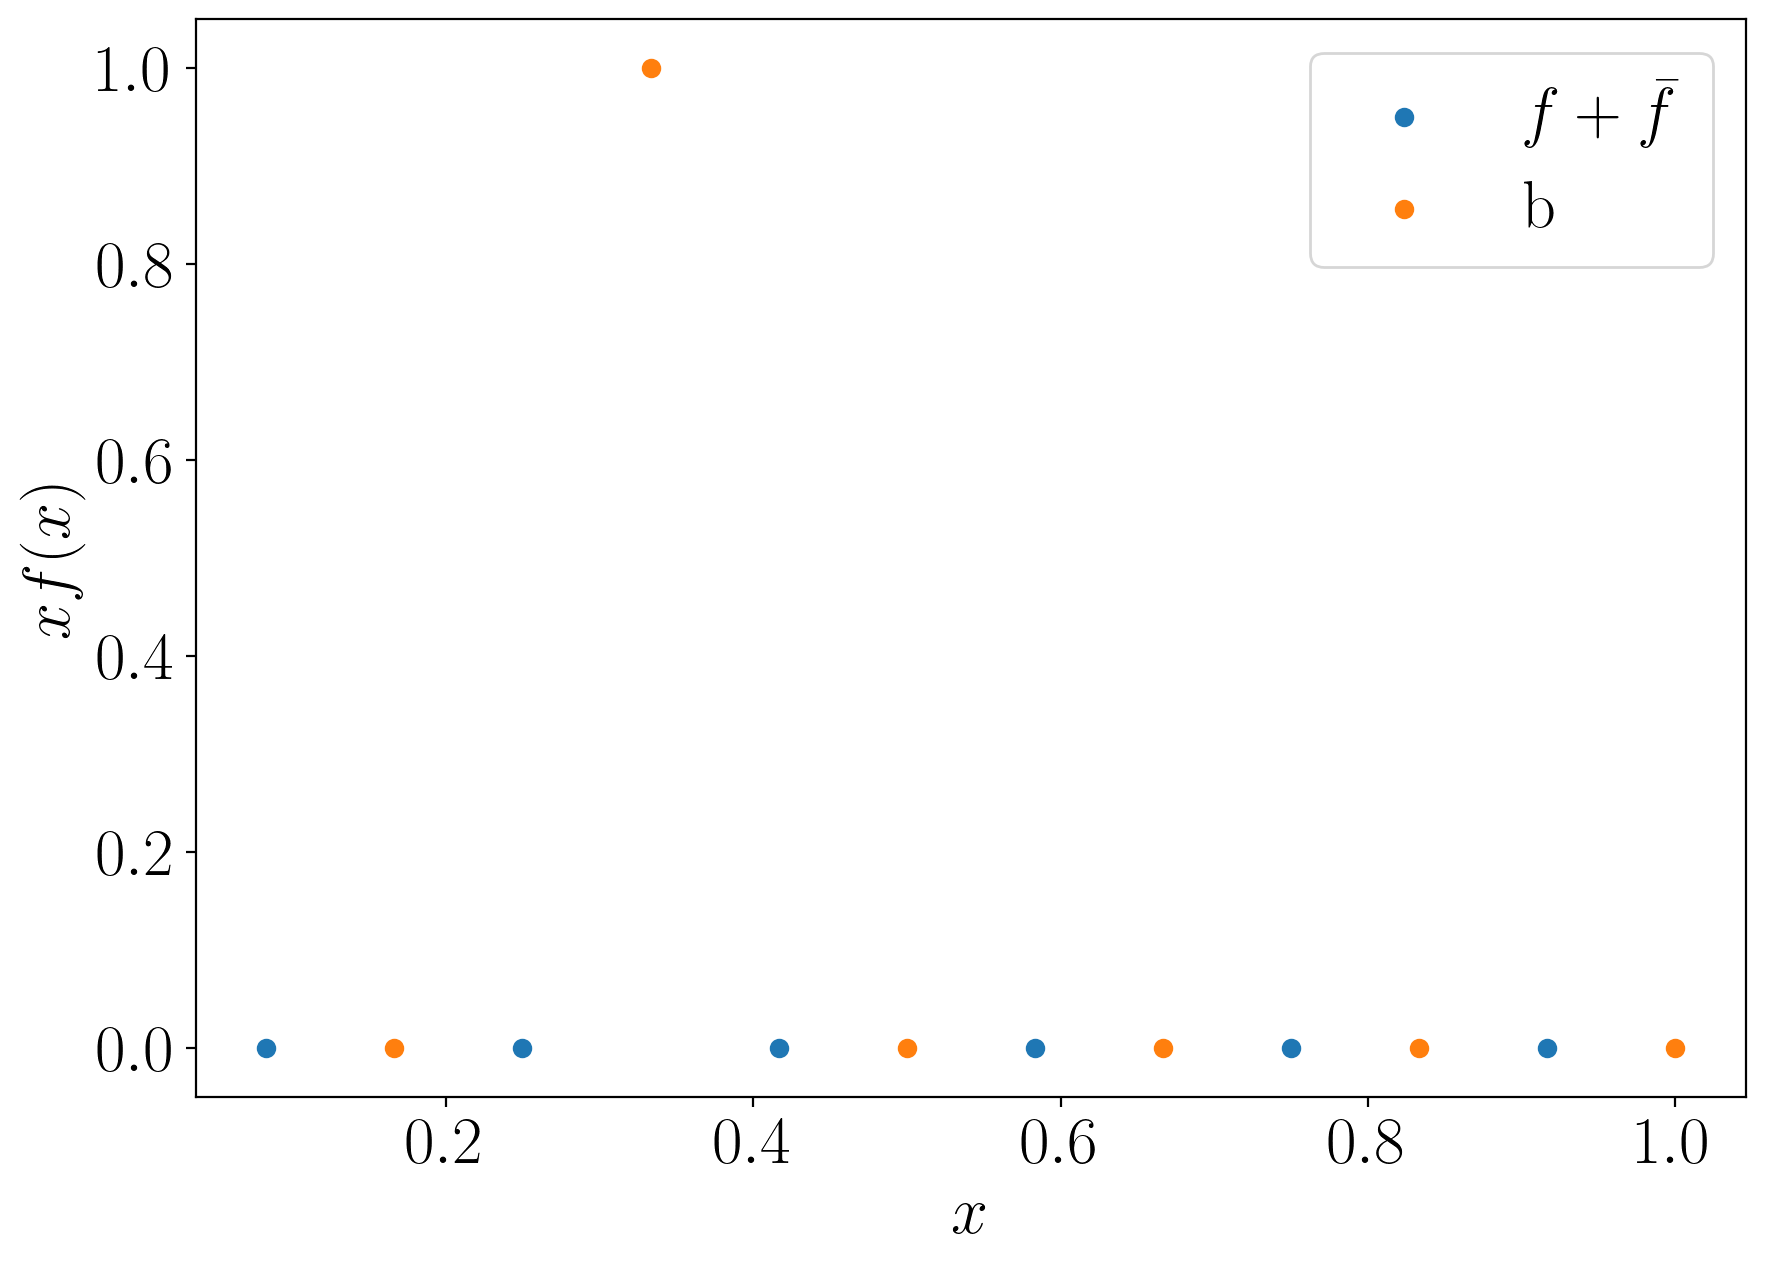

In [351]:
eigenstate = 4

psi = numpy_to_fock(vecs[:, eigenstate], basis)
max_weight, _ = max_fock_weight(psi)


fermion_pdf = pdf(res, psi, 'fermion')
antifermion_pdf = pdf(res, psi, 'antifermion')
boson_pdf = pdf(res, psi, 'boson')

x_fermion = np.array([k/res for k in np.arange(1/2, res, 1)])
x_boson = np.array([k/res for k in np.arange(1, res + 1, 1)])


plt.figure(figsize = (10, 7), dpi = 200)

if np.allclose(fermion_pdf, antifermion_pdf):
    plt.scatter(x_fermion, 2 * x_fermion * np.real(fermion_pdf), label = r'$f+ \bar{f}$')

else:
    plt.scatter(x_fermion, x_fermion * np.real(fermion_pdf), label = f'Fermion')
    plt.scatter(x_fermion, x_fermion * np.real(antifermion_pdf), label = f'Antifermion')
plt.scatter(x_boson, x_boson * np.real(boson_pdf), label = f'b')
# plt.scatter([], [], color = 'white', label = f'{max_weight}')
plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$xf(x)$')
# plt.title(f"Yukawa $Q = {baryon_number}$ bound state PDF")

In [2]:
import time

In [3]:
def get_renormalized_eigenstates(resolutions, t,  g, mf, mb, Q, num_eigenstates, n_particles: int = None):
    eigenvalues = []
    eigenstates = []

    initial_time = time.time()
    for res in resolutions:
        print("---K = ", res, "---")
        res_time_init = time.time()
        hamiltonian = renormalized_Yukawa_hamiltonian(res = res, t = t, treg = 0, g = g, mf = mf, mb = mb)
        print("Size of Hamiltonian:", len(hamiltonian))
        print("Hamiltonian generated in:", time.time() - res_time_init)
        res_time_init = time.time()
        res_tmp_basis = momentum_states_partition(res, n_particles = n_particles)
        print("Basis generated in:", time.time() - res_time_init)
        res_time_init = time.time()
        baryon_number_basis = impose_baryon_number(res, res_tmp_basis, baryon_number=Q)
        res_time_init = time.time()
        
        print("Generating", len(baryon_number_basis), "x", len(baryon_number_basis), "Matrix...")
        # tmp_mat = generate_matrix(hamiltonian, cutoff_basis)
        tmp_mat = generate_matrix_hermitian(hamiltonian, baryon_number_basis)
        print("Matrix generated in:",  time.time() - res_time_init)
        res_time_init = time.time()


        # tmp_mat = generate_matrix(hamiltonian, baryon_number_basis)
        if tmp_mat.shape != (0, 0):
            print("Calculating eigenvalues...")
            vals, vecs = np.linalg.eigh(tmp_mat)
            print("Eigenvalues calculated in:", time.time() - res_time_init)
            vals = sorted(vals)

        if num_eigenstates != 'all':
            eigenvalues.append(vals[:num_eigenstates])
            for i in range(0, num_eigenstates):
                eigenstates.append(numpy_to_fock(vecs[:, i], baryon_number_basis))
        else: 
            num_eigenstates = len(baryon_number_basis)
            eigenvalues.append(vals[:num_eigenstates])
            for i in range(0, num_eigenstates):
                eigenstates.append(numpy_to_fock(vecs[:, i], baryon_number_basis))
        
    
    max_eigenvalues = max(len(eig) for eig in eigenvalues)

    padded_eigenvalues = np.array([
        np.pad(eig, (0, max_eigenvalues - len(eig)), constant_values=np.nan)
        for eig in eigenvalues
    ])

    padded_eigenvalues = padded_eigenvalues.T
    # print("All renormalized eigenvalues are positive:", all(padded_eigenvalues > 0))
    assert all(padded_eigenvalues > 0)
    return padded_eigenvalues, eigenstates

In [10]:
max_res = 7
mf = 1
mb = 0.1
g = 1
t = 0.1
Q = 0
n_particles = 2
num_eigenstates = 'all'

resolutions = [max_res]
# resolutions = np.arange(2, max_res + 1, 2)
renormalized_eigenvalues, renormalized_eigenvectors = get_renormalized_eigenstates(resolutions, t = t, g = g, mf = mf, 
                                                                                   mb = mb, Q = Q, num_eigenstates = num_eigenstates, n_particles = n_particles)

---K =  7 ---


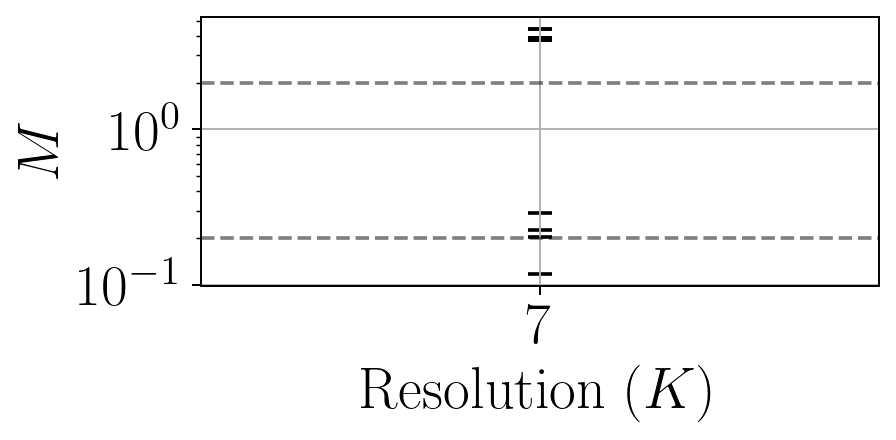

In [8]:
plt.figure(figsize = (5, 2), dpi = 175)
colors = plt. cm.viridis(np.linspace(0, 1, renormalized_eigenvalues.shape[0]))
for i, eig in enumerate(renormalized_eigenvalues):
    # plt.scatter(resolutions, np.sqrt(eig),  color = colors[i], marker = '_', s = 100, label=rf"$E_{{{i}}}$")#
    plt.scatter(resolutions, np.sqrt(eig), color = 'black', marker='_', s = 100)

plt.xlabel("Resolution ($K$)")
plt.ylabel("$M$")
plt.axhline(y = 2*mf, color = 'k', linestyle = '--', alpha = 0.5) 
plt.axhline(y = 2*mb, color = 'k', linestyle = '--', alpha = 0.5) 
# plt.title( f'$t = {t}$,$g = {g}$, $m_f$ = {mf}, $m_b$ = {mb}')
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5),
#           fancybox=True, shadow=True, ncol=np.ceil(len(renormalized_eigenvalues)/6))
plt.yscale('log')
plt.xticks(resolutions)
plt.grid()
plt.show()

(-0.1, 1.1)

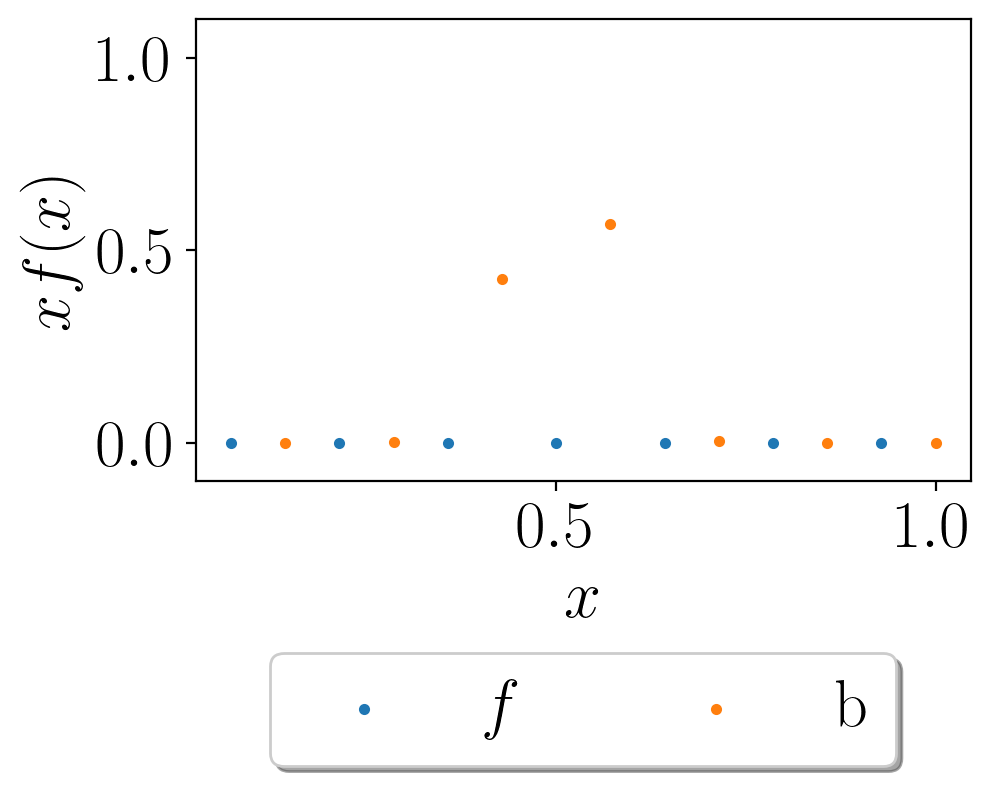

In [222]:
psi = renormalized_eigenvectors[0]
res = max_res

fermion_pdf = pdf(res, psi, 'fermion')
antifermion_pdf = pdf(res, psi, 'antifermion')
boson_pdf = pdf(res, psi, 'boson')

x_fermion = np.array([k/res for k in np.arange(1/2, res, 1)])
x_boson = np.array([k/res for k in np.arange(1, res + 1, 1)])


plt.figure(figsize = (5, 3), dpi = 200)

# if np.allclose(fermion_pdf, antifermion_pdf, 1e-3, 1e-3):
#     plt.scatter(x_fermion, 2 * x_fermion * np.real(fermion_pdf), marker = '.', label = r'$f+ \bar{f}$')

plt.scatter(x_fermion, x_fermion * np.real(fermion_pdf), marker = '.', label = f'$f$')
# plt.scatter(x_fermion, x_fermion * np.real(antifermion_pdf),marker = '.',  label = f'Antifermion')
plt.scatter(x_boson, x_boson * np.real(boson_pdf), marker = '.', label = f'b')


# plt.scatter([], [], color = 'white', label = f'{max_weight}')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=2)
plt.xlabel(f'$x$')
plt.ylabel(f'$xf(x)$')
plt.ylim(-0.1, 1.1)
# plt.title(f"Yukawa $Q = {baryon_number}$ bound state PDF")

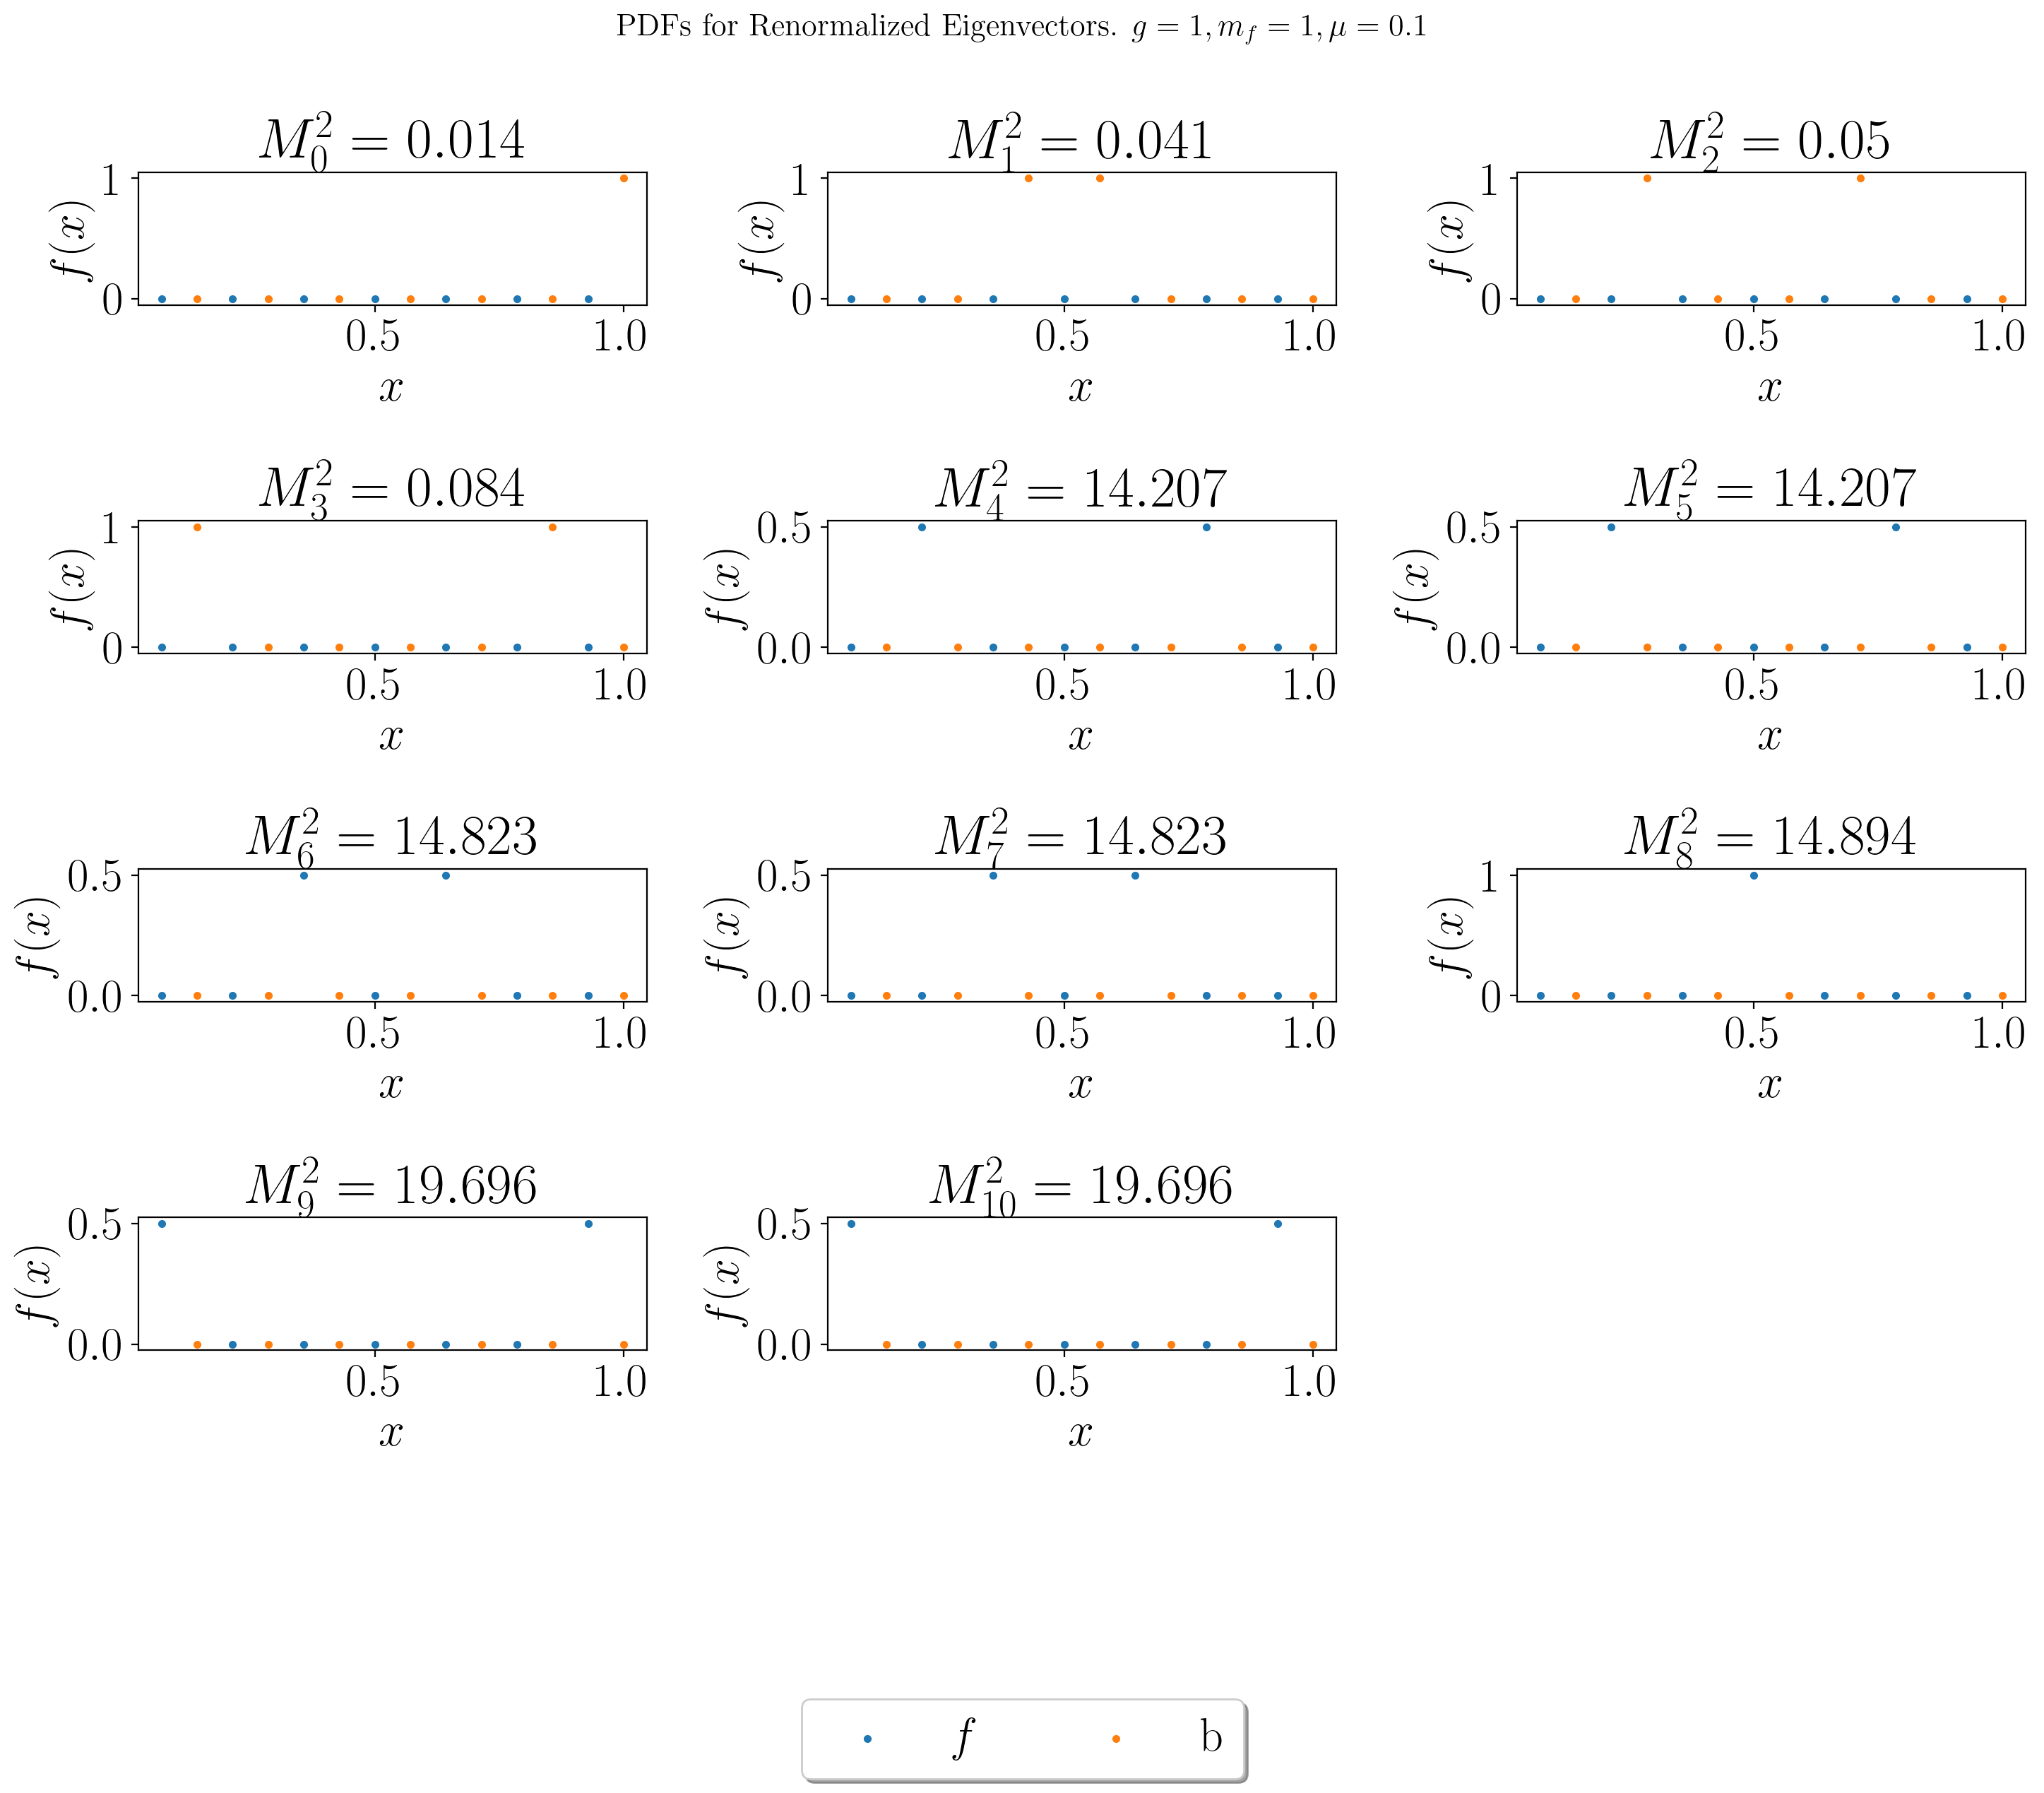

In [9]:
# Assuming `renormalized_eigenvectors` is a list or array of eigenvectors
num_eigenvectors = len(renormalized_eigenvectors)

# Determine grid size (rows and columns)
cols = 3  # Adjust based on preference
rows = (num_eigenvectors + cols - 1) // cols  # Ceiling division

# Create a figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3), dpi=200)

# Flatten axes for easy iteration
axes = axes.flatten()

# Create legend handles and labels
handles, labels = [], []
res = max_res
for idx, ax in enumerate(axes):
    if idx < num_eigenvectors:
        psi = renormalized_eigenvectors[idx]
        fermion_pdf = pdf(res, psi, 'fermion')
        antifermion_pdf = pdf(res, psi, 'antifermion')
        boson_pdf = pdf(res, psi, 'boson')

        x_fermion = np.array([k / res for k in np.arange(1 / 2, res, 1)])
        x_boson = np.array([k / res for k in np.arange(1, res + 1, 1)])

    
        scatter_fermion = ax.scatter(x_fermion, np.real(fermion_pdf), marker='.', label='$f$')

        if idx == 0:
            handles.extend([scatter_fermion])
            labels.extend(['$f$'])

        scatter_boson = ax.scatter(x_boson, np.real(boson_pdf), marker='.', label='$b$')
        if idx == 0:
            handles.append(scatter_boson)
            labels.append('b')

        ax.set_xlabel('$x$')
        ax.set_ylabel('$f(x)$')
        # ax.set_yscale('log')
        ax.set_title(f"$M_{{{idx}}}^2 = {round(renormalized_eigenvalues[idx][0], 3)}$")
    else:
        ax.axis('off')  # Hide unused subplot axes

fig.suptitle(f"PDFs for Renormalized Eigenvectors. $g = {g}, m_f = {mf}, \mu = {mb}$", fontsize=16)
# Add a single legend outside the grid
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=len(labels))


# Adjust layout
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space for the legend
plt.show()